# RL4CO Quickstart Notebook

In this notebooks we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should take less than a minute!  🚀

### Imports

In [1]:
from omegaconf import DictConfig
import torch
import lightning as L

from rl4co.envs import TSPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.models.nn.utils import random_policy
from rl4co.tasks.rl4co import RL4COLitModule

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## Simple rollout with a random policy

This policy selects random actions from the available ones

Tour length: 11.96


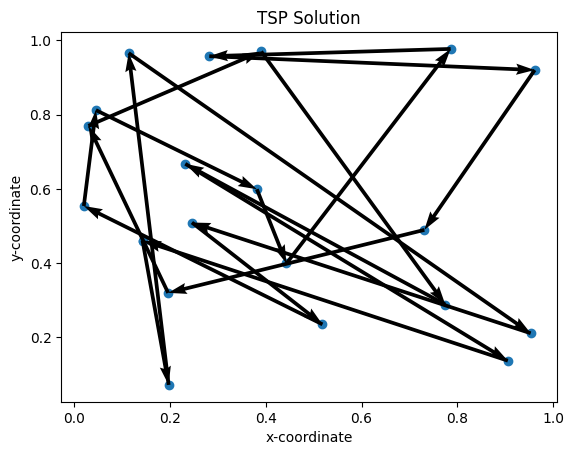

Tour length: 9.98


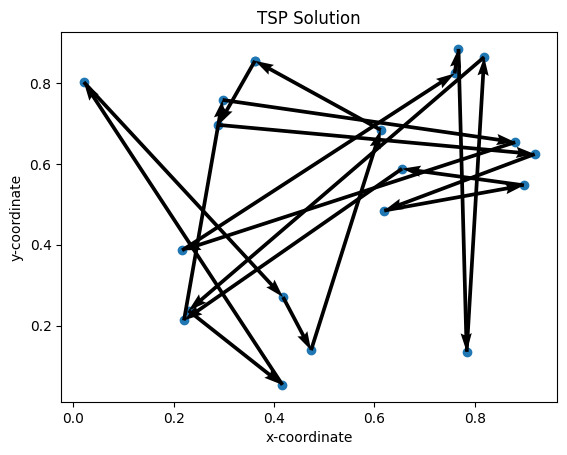

Tour length: 10.08


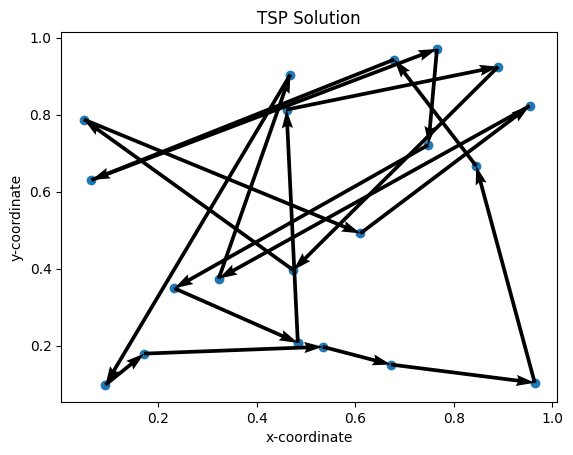

In [2]:
env = TSPEnv(num_loc=20)
td_init = env.reset(batch_size=[3])
td = env.rollout(100, random_policy, tensordict=td_init, auto_reset=False)
actions = td['action']
reward = env.get_reward(td_init, actions)

for i in range(3):
    print(f"Tour length: {-reward[i]:.2f}")
    env.render(td_init[i], actions[i])

## Configuration

Here we define the configuration for the experiment

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = DictConfig(
    {"data": {
            "train_size": 100000,
            "val_size": 10000, 
            "batch_size": 512,
        },
    "optimizer": {"lr": 1e-4}}
)


model = AttentionModel(env) # AttentionModel based on REINFORCE with greedy rollout baseline
lit_module = RL4COLitModule(config, env, model) # LightningModule for training

## Training

We train for just 3 epochs to showcase the training loop. Depending on your hardware, this may take less than one minute!

In [4]:
# Trainer
trainer = L.Trainer(
    max_epochs=3, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
batch_size under data specified, using default as 512
No train_batch_size under data specified, using default as 64
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TSPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
----------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Plot results

Tour length: 4.37


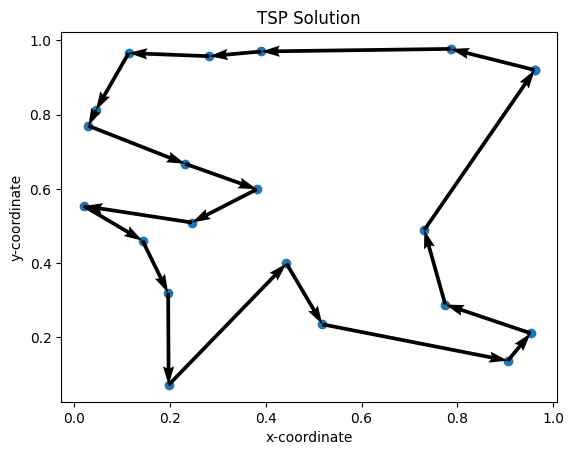

Tour length: 3.85


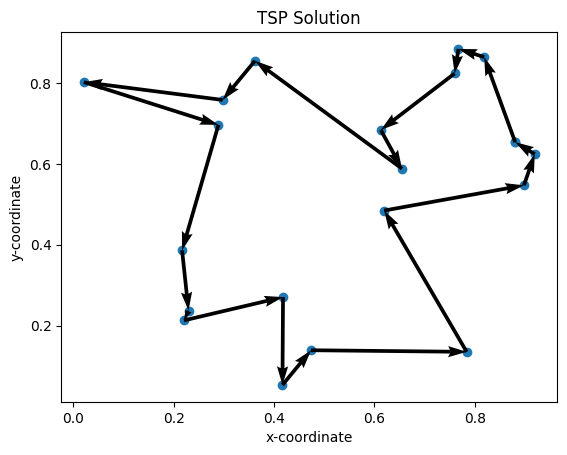

Tour length: 4.61


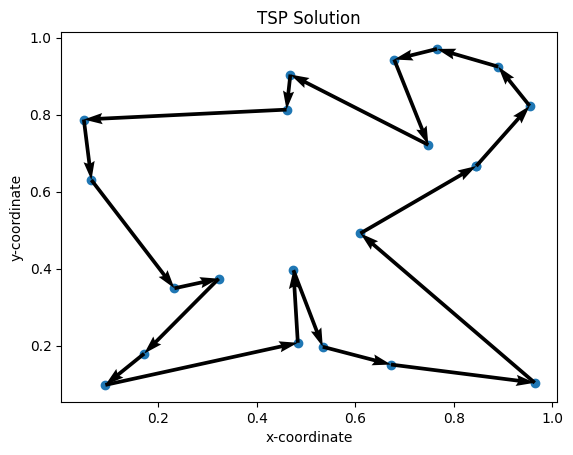

In [5]:
model = lit_module.model.to(device)
td = td_init.to(device) # let's take the one we plotted before
out = model(td, phase="test", decode_type="greedy", return_actions=True)

actions = out['actions'].cpu()
for i in range(3):
    print(f"Tour length: {-out['reward'][i]:.2f}")
    env.render(td_init[i], actions[i])

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉